# Value Netwrok Project Summary

## 1. 背景介绍
本文档目的在于介绍价值网络（value network）项目调参的实现细节，共分为6小节。其中前三小节 *1.背景介绍，2.原始数据，3.数据处理*  描述了项目实现过程中基本的思想和基础的数据处理。后三小节 *4.实验方案, 5.其他尝试, 6.结论总结*  记录了模型调参优化的过程和结果。

### 1.1 AlphaGo value network
论文中详细描述value network的地方有两处，一是3.Reinforcement Learning of Value Networks，另一处是 Methods/Value Network: Regression。

前者描述述了价值网络的思想设计，后者介绍了生成自对弈数据集的细节。以下列出其中相对关键的信息。

#### 1.1.1 设计思想
 - 价值网络预测的是：使用其策略网略落子在位置s后，由策略网络自对弈至终局，即将落子的当前玩家获得的最终期望奖励。$v[p](s) = E[Z[t] | S[t] = s,a[t...T] ∼ p]$
 - 对所有非终态(t < T) 的奖励为0，给数据标label时，$z[t] = ±r(s[T])$ 
 - 棋盘连续位置强相关，导致模型容易过拟合。
     - 在只使用KGS的数据集(含有300万个棋盘位置)回归时，测试集MSE为0.37。训练集为0.19。
     - 为解决上述问题，使用自对弈产生新的数据集，新数据集包含300万个不同的棋盘位置，训练时从每盘中单独采样一个样本。将训练集和测试集上的MSE分别降为0.226和0.234。

#### 1.1.2 生成数据集
 生成新的数据集有三个阶段，设一局棋需要T步可以终局，将这T步分成三个阶段，1...U-1, U, U+1...T。其中U ∼ unif{1,450}
 
 1. 先用监督学习得出的policy network生成前U-1步
 2. 从合法动作里，随机选择一个动作，执行第U步
 3. 最后使用强化学习得出的policy network从U+1步开始自对弈到终局
 
从新数据集每局对弈中采样一条加入训练集，这一条是其中第U步下完后的State[U+1]和终局奖励Z[u+1]

### 1.2 最初设计
从AlphaGo的value network出发，结合斗地主区分明牌暗牌的情况，设计了三种value network的应用场景。

 1. 明牌，用于帮助MCTS回溯更新权值
 2. 暗牌，用于评估自己当前（打前或打后）的赢面来选择动作
 3. 暗牌，用于评估他人赢面，反过来选择自己的动作。
 
实际训练可使用的是第二种方案。
### 1.3 例子
由于训练数据全为暗牌数据，拿暗牌模型训练明牌模型不够合理。故后面的尝试主要关注应用2和3上。

#### 1.3.1 用于暗牌且评估自己（打前）的赢面 :有助于提升MCTS simulation的效率
1. 玩家player_1，在某次出牌之际，模型预测出合法动作列表actions, 其中每个元素actions[i]为各个动作。
2. **将每个动作转化为cards_played_this_hand的平面加入input_builder，与出牌相关的其他局势信息没有变化，仍为打前状态。** 评估当前玩家player_1当前的赢面。因此由a[i]可产生对应的价值列表values_for_self[i]。
3. 降序排序价值列表values_for_self，则本次出牌实际选择为values[0]对应的动作

#### 1.3.2 用于暗牌且评估自己（打后）的赢面：用来打牌
1. 玩家player_1，在某次出牌之际，模型预测出合法动作列表actions, 其中每个元素actions[i]为各个动作。
2. 将每个动作带入到当前局势，**评估当前玩家player_1执行该动作后的赢面**。因此由a[i]可产生对应的价值列表values_for_self[i]。
3. 降序排序价值列表values_for_self，则本次出牌实际选择为values[0]对应的动作

#### 1.3.3 用于暗牌且评估他人的赢面：用来打牌
1. 玩家player_1，在某次出牌之际，模型预测出合法动作列表actions, 其中每个元素actions[i]为各个动作。
2. 将每个动作带入到当前局势, **评估执行这个动作后下家玩家player_2所面临局面的赢面**。因此由a[i]可产生对应的价值列表values_for_next_player[i]。
3. 降序或升序(取决于下家与当前玩家是否敌对关系)排序价值列表values_for_next_player，则本次出牌实际选择为values_for_next_player[0]对应的动作


## 2. 原始数据

- 训练模型使用过两份数据，一份是玩家真实的日志game_log，一份是模仿AlphaGo生成数据集的方法所产生的数据battle_log
- 对战数据由于筛选要求特殊见3.4和3.1第二种pass采样，最终用于训练的大约有360w条数据
- 在同等条件下，batch_size =64, num_epochs=3, game_log可以训练模型到step 400k，battle_log只训练到step 180k

|    名称   |   描述    |文件大小  |    局数   |                          路径                      |
| ----------  | ----------- |--------- | ----------- |------------------------------------------------------------------------  |
| game_log   |  玩家日志   | 26 G   | 692w      |/data/cards_data/value_network_ftl3/grouped_game_records_b_8_23.txt.train |
| battle_log  |  自对弈日志 | 23 G    | 727w      |/data/cards_data/value_network_ftl3/battle_logs/ftl3_battle_log_20180314_xa[a-z].train|


### 3 数据处理

### 3.1 对pass的处理
 - 训练模型的原始日志数据中，pass动作的数量是其他出牌动作的十倍之余，为避免数据不平衡对模型有所影响，故在训练前对日志中的pass动作提前进行采样。
 
 - Pass处理：考虑了两种采样方式，主要区别在于是否剔除无牌可出的pass。
     - 在原始日志中，剔除所有无牌可出的pass，只留下策略性pass，再对pass以概率0.35采样
     - 在原始日志中，对pass以概率0.1采样
 
 - 经过采样，避免了pass数量占比过大的问题，最终pass数量与其他出牌类型数量相近。具体细节参考:[pass_data_statistic](../value_network_train_data_experiments/pass_data_statistic.ipynb)


### 3.2 将value network应用于牌局后半段

曾经考虑过将value network应用于打牌后半段，以解决局末农民配合不佳的问题。采用张数作为衡量是否进入关键时期的标准。

故训练数据的采样范围需限定在最后几手内，对于这个问题，我们有如下考虑：
1. 当三个玩家有一人的手牌张数小于特定值*X*时，即认为该局进入关键时期
2. 通过统计日志，设定了X = 7, 进行采样，方法如下。

#### 统计牌局
在由若干条日志组成的完整一局对弈中，我们关注最后一条日志时，即最后一个动作执行前，三个玩家手牌张数中的最小值，写入cards_left_1.csv。

再关注倒数第二条日志，即还剩两个动作该局终局时，三个玩家手牌张数中的最小值，写入cards_left_2.csv。 

以此类推，我们统计了30万局日志，可以发现当X=7时，可涵盖90%以上的最后4手，60%以上的最后9手。具体数据统计参考: 
[cards_left_hand](cards_left_hand.ipynb)

#### 结果
- 可将如上数据训练第4章中的若干模型。
- 在ai-board的体验上从policy network转化为value network，需要三个玩家手牌张数的最小值小于设定值的条件来启动。
- 最终打牌表现一般，不够好，故后续不再单独赘述。


### 3.3 使用样例及代码流程
运行*value_data_iter.py* 进行以上处理，*python value_data_iter.py* 后面跟着五个参数

 1. **pass 采样率**：筛选pass的比率，e.g.：0.07, 0.1，0.35
 2. **一局取几手**：从完整的game log里取几条数据，e.g.：0，1，5。其中0为全取
 3. **是否是明牌模型**：明牌为1，暗牌为0
 4. **是否是value network**：模型输出value为1，输出q值为0
 5. **截取后几手时三个玩家手牌张数最小值self.min_len**：e.g. 0, 7。其中0表示不采样，7表示当玩家手牌最小值小于等于7时允许采样。

对一局游戏中的一条日志，进入value_data_iter.py会经历以下采样，以下给出一个例子及其采样流程图

1. 判断是当前状态player.state是否是正常而非托管，是则留下，否则筛去；
2. 计算当前单个玩家各自拥有手牌的最小值min_len。若输入参数self.min_len为0则进入3；否则，判断当前min_len是否满足小于self.min_len的条件，若满足，留下，若不满足，筛去；
3. 如果这手出牌了，那么留下，结束；如果这手为pass，则判断是否存在可出牌，存在进入4，否则留下。
4. 生成一个0到1的随机数，若这个数大于设定的pass采样率，则筛掉，否则留下，结束
5. 若数据成功留下，再在一局里随机选5手



In [5]:
# EXAMPLE
# 是否去掉无牌可出的未使用参数，写在函数filter_action()
# python value_data_iter.py infile.log outfile.json 0.35 5 0 1 7


![数据采样流程图](img/flow_cahrt.png)


### 3.4 自对弈数据生成
- 参考1.1.2节描述的数据生成方式，自对弈生成数据也分为三个阶段。
     - 1..U-1步，较弱策略模型bot0创建较为丰富的盘面
     - 第U步，随机选择一个合法动作
     - U+1...T, 较强的策略模型bot4获得最终的输赢结果
 
- 由于自对弈生成时playaction的属性player_state不被占用，此时就用来表达这条日志属于哪个阶段，在代码中分别以0, 1, 2表示。
- 之所以首先用bot0打一段再随机选一步的原因是，为了创造丰富的盘面，但是不能太过随机。否则过于随机的盘面在真实情况中很少存在，无整体的趋势。
 
- 其中bot0和bot4只有major部分模型不同，预测翅膀的minor模型为同一个。（模型路径基于devnet。）
 
|  id |   描述    |                                            major   |    minor    |
| -----  | ----------- |------------------------------------------------------------------------ | -------------- |
| bot0  |  较弱模型   | /ai_model_data/ftl3_multi_levels_second_201802/ftl3-bot-4-model-400000  | ftl3/minor/20170818_minor/CNNModel/checkpoints/model-35800         |
| bot4  |  较强模型   | /ai_model_data/ftl3_multi_levels_second_201802/ftl3-bot-0-model-400000  |  同上       |


#### U的选择
在Alpha-go论文中，U ∼ unif{1,450}。适用于我们的模型，均匀分布的最大值需要重新设定。
- 统计了9000多局真实日志中，每局游戏总共的日志条数，如下图所示。
- 可以考虑设均匀分布的最大值为40，将涵盖大部分情况

**后续数据的筛选后，我们也进行了数据分布统计，验证了轮次（一局的手数）是符合原数据分布的*

#### 特殊情况处理
当U∼ unif{1,40}时可能出现以下情况：
 - 当u = 30, 某一局可能打到第20手就结束了。
 - 那么该局所有日志都由bot0打出，则采样时不存在第U步下完后的State[U+1]和终局奖励Z[u+1]。
 - 该局筛去，不采样。

In [6]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame

# pd.set_option('display.mpl_style', 'default') # Python 2
plt.style.use('fivethirtyeight') # Python 3
plt.rcParams['figure.figsize'] = (15, 5)

def cards_type_distributed(file_path, title="bar", feild_name ="cards_left", hist_type="barh"):
    # read josn file and get cards_play_this_hand and labels
    game_log = pd.read_csv(file_path)
    cards_played_this_hand = game_log[feild_name]
    cards_played_counted = cards_played_this_hand.value_counts()
    
    cards_played_counted=cards_played_counted.sort_index()
    
    plt.rcParams['figure.figsize'] = (15, 5)
    cards_played_counted.plot(hist_type, title=title)
    return cards_played_counted
    

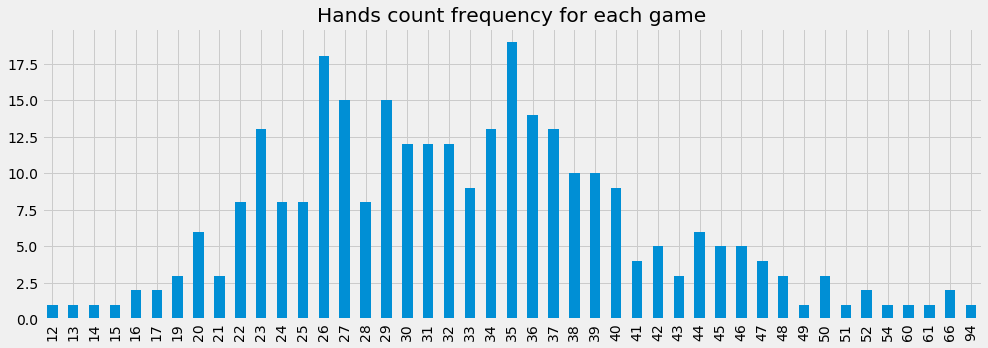

In [7]:
cards_played_counted = cards_type_distributed("./data/hands_cnt.csv", "Hands count frequency for each game", "hands_cnt", "bar")
# print cards_played_counted


## 4. 实验方案

### 4.1 基本input_builder
对各个模型的修改和调整主要分为两大方面，一个是构造input_builder的修改，一个是对模型结构的修改。尤其针对打前打后的不同状态，即主要针对input_builder的修改。

这里首先介绍input_builder所有不同平面。总共13类，每个类别末尾用【x】标记该类占多少平面(有助于对模型层数的统计)。

1. 判断地主或农民：全1是农民，全0为地主 【1】
2. 手牌(cards_at_hand)【1】
3. 除了打出的牌(cards_hold_by_all） 【1】
4. 是否是上一个活跃玩家(is_last_active_role） 【1】
5. 上一个活跃玩家是谁(player_role of the last active player）：1是地主，0是农民 【1】
6. 上家出的牌(cards_last_played）【1】
7. 当前玩家是第几个玩家：用0,1,2标识身份，转化为三个平面。 【3】
8. 轮次信息: 10个平面 【10】
9. 当前玩家已打出的牌(cards_played）【1】
10. 其他两玩家打出的牌：[cards_played_by_palyer_1, cards_played_by_player_2] 【2】
11. 历史出牌信息(history_hand)：当选取之前5手出牌信息时，此属性为一个长度为5的列表。当游戏不足5手时，不存在的出牌补Cards()。【5】
12. 三人手牌信息：当为明牌是cards_at_hand_list；当为暗牌是手牌张数cards_at_hand_no_list；顺序为[上上家，上家，当前玩家]【3】
13. 这一手的出牌(cards_played_this_hand）：可看做动作平面 【1】

如果所有平面都采用，那么总共会有31个平面。
后续讨论的5个模型除第一个模型外，其余4个全都采用暗牌，且不包含轮次信息。即最多21个平面。

接下来的几小节主要介绍若干个实验模型及其优化。其中V+ 代表评估打前状态的价值网络，V- 代表评估打后的状态价值网络。a代表当前动作action。
除非特殊说明，训练采用的默认参数为：
 - hidden_layer：4
 - filter_sizes_dim0:[[5],[5],[3],[1]]
 - filter_sizes_dim1:[[15],[5],[3],[1]]
 - num_filters :[32,64,64,96]
 - dense_loss_type: 2 (2 for huber,1 for mse)
 - num_epochs: 64
 - num_epochs: 3
 - learning rate: 0.001
 - add round: False
 ---
 
 #### 说明
 
 - 由于价值网络与策略网络相差较多，对战实力悬殊，故以下的对战结果多采用价值网络之间对弈。
 - 实际评价模型效果时，以ai-board上模型表现为准。当模型表现过差时，将不再对战。

### 4.2 Model-1：V+ 和 game_log

#### 设计
 - 模型名称: 20180229_seen_btc64_his5_huber_rdcMean_l2001_lr0_ep3
 - 应用场景：明牌，评估当前玩家打前的赢面；不能用来选择当前玩家出牌动作打牌，只用作赢面评估；但可评估下家赢面，来选择自己的动作
 - 训练数据：采用原始游戏玩家日志，只经过了第二种pass采样，采样比例为0.1
 - input_builder: 采用4.1节所有input_builder的基础上，去掉了*8.轮次信息*，*13.这一手的出牌*
 - 网络结构：采用RegressionCNN，但在最后一层全连接前再增加一层全连接，使原本长度为256的输出不要那么急速回归到1个值。此方法参考了算法二组前期的价值网络。我们后期优化发现没有提升，反而去掉这多余的一层，效果更优。之后的所有模型都去掉了这一层全连接。
 
#### 评估
 - Loss
     - training loss：0.22
     - test loss：0.47

 - 对战: 评估下家赢面，取使下家赢面最大或最小的动作出牌
     - Model-1 v.s. policy network: [18, 41, 41]; [94, 5, 1] for reverse
     
     
#### 缺陷
 - 实际体验中发现，价值网络会出现较多不智能的“不出”
 - 训练过程来回抖动，过拟合问题相对明显，目前训练loss为0.22，测试数据为0.5左右
 - 基于这一版模型，进行了许多细节性优化，部分有效，但提升不大，具体参考 *5.其他尝试*

### 4.3 Model-2：Q(s,a) 和 game_log

#### 设计

- 模型名称：20180303_blind_self_q_value_full_conn_256_action_connn与20180301_blind_self_q_value_no_full
- 训练参数： 前一个模型hidden_layer=3,filter_sizes_dim0 =filter_sizes_dim1=[[5],[3],[1]],num_filters=[32,64,64];  后一个模型保持默认参数
- 应用场景：暗牌，输入当前玩家打前的局面，和执行的出牌动作，评估此动作在此状态下的价值。
- 训练数据：采用原始游戏玩家日志，只经过了pass采样，采样比例为0.1
- input_builder: 采用4.1节所有input_builder的基础上，去掉了*8.轮次信息*，*13.这一手的出牌*
- 网络结构：两个模型区别在于尝试了两种结构，都是在Model-1的基础上进行了一些调整。从MSE上来看，*action拼接*的这种更好

    1. action拼接
     - 将action作为一个平面，拉开成75的向量，与模型评估的state输出的128维向量拼接在一起。提到Model-2时，默认为此网络结构的模型。
     - test集上的MSE=0.665399
     - 该模型后来在讨论中被认为比较奇怪，后来放弃。
     - 参考: ![模型结构](img/model-q.png)
    2. action在前
     - 将action作为一个平面，添加在input_builder里，即添加了4.1中的*13.这一手的出牌*
     - test集上的MSE=1.36325
 

#### 评估
 - Loss(20180303_blind_self_q_value_full_conn_256_action_connn)
     - training loss：0.32
     - test loss：0.665
 - 主观
     - 评估当前玩家赢面，在ai-board上观察，不智能，但比model-1有提升     
     
#### 缺陷

##### action拼接
 - 出大牌,开局王炸,后跟出长牌,长顺子
 - 没有主动不出的策略

##### action在前
 - 第一把永远出顺子，喜欢最长顺子
 - 倾向出大牌，KKKKA 22BR ==> KKK22
 - 未见过飞机带翅膀

**使用过battle_log训练，效果不好，没有Model-4优秀*

---

### 4.4 Model-3：V- 和 game_log
#### 设计
 - 模型名称: 20180308_v_huber_blind_pass035_blind_self_afterState和20180307_v_huber_blind_pass01_blind_self_afterState
 - 应用场景：暗牌，输入当前玩家打前的局面，和执行的出牌动作，评估此动作在此状态下的价值，同上。
 - 训练数据：两个模型区别在于使用了不同采样方法的训练数据，详见3.1。
 - input_builder: 采用4.1节所有input_builder的基础上，去掉了*8.轮次信息*，*13.这一手的出牌*，并将*2.手牌*修改为出牌后的手牌
 - 网络结构：默认采用RegressionCNN。
 
#### 评估
 - Loss(20180303_blind_self_q_value_full_conn_256_action_connn)
     - training loss：0.34
     - test loss：0.827
 - 主观
     - 在ai-board上观察，不够智能，依然无脑出大牌，但严重程度比model-2弱化一些
     - 能够命中一小部分policy network的预测，甚至存在比policy打的更好的情况
     
 - 对战: 评估当前玩家赢面，取赢面最大的动作出牌
     - Model-3-pass0.35 v.s. Model-1-pass0.1: [58, 26, 16]; [29, 31, 40] for reverse：采用pass-0.35的模型表现更优
     
#### 缺陷
- **出大牌**，一上来AAA22，BR 这个问题明显，带牌也倾向带大牌
- F2出完了，估计L的赢面是0.8？——显然错误
- 容易拆对子组长顺子
- 出单张，自由出牌剩一队3，出单张3

##### 其他信息
 - 除去pass的情况后，policy（即第一选择）大多排在value的中后部分
 - 共63手，8手bid，实际出手55次，30次pass，前其中26手是被迫pass
 - policy预测为pass top时，value一般也会选择pass；但是非top时，也会选择pass，结果地主出牌保守一直pass。
 ---

### 4.5 Model-4：V- 和 battle_log
#### 设计
 - 模型名称: 20180313_v_huber_blind_pass035_blind_battle_afterState
 - 应用场景：暗牌，评估当前玩家打后的赢面，选择打后赢面最大的动作
 - 训练数据：基于对战日志，采用3.1中pass采样的第二种方法，即pass0.35的方法，组成训练集。
 - input_builder: 同Model-3，采用4.1节所有input_builder的基础上，去掉了*8.轮次信息*，*13.这一手的出牌*，并将*2.手牌*修改为出牌后的手牌
 - 网络结构：默认RegressionCNN。
 
#### 评估
 - Loss
     - training loss：0.35
     - test loss：0.685
 - 主观
     - 前四个模型里相对最优的一个模型，学会了打小牌
     - 倾向打小牌，能够命中许多policy network预测的top action
     
 - Battle:评估当前玩家赢面，取赢面最大的动作出牌
     - Model-4 v.s. Model-3：[35,41,23], [35,33,32] for reverse
     

#### 缺陷
 - 过于保守，太过保留大牌，学不会出炸弹。  
 - 部分出牌不智能，存在拆炸弹或三张
 ---

### 4.6 Model-5：{V-, V+, a} 和 battle_log

#### 模型缺陷分析

目前为止，以上5个Model，分别有一些突出的缺陷：
- Model-2（Q(s,a) 和 game_log）：出大牌，出长顺子
- Model-3（V- 和 game_log）：出大牌，出长顺子
- Model-4（V- 和 battle_log）：出小牌，保留大牌


- Model-2是训练Q模型，会更关注action的动作平面。模型倾向于出大牌和长顺子，即打出去的牌越大越多，自己张数减少越多，其他人越有可能无牌可出。
- 而Model-3虽然没有包含有出牌action动作平面，但是gane_log的出牌存在不平衡的现象，正样本的数据的出牌有大牌的倾向，参考[pass_data_statistic](../value_network_train_data_experiments)，模型可能学会多出大牌以贴近正样本情况。
- 根据Model-4的表现我们认为，单纯评估的打后状态，模型会倾向于使留在手里的牌越大越好。
- 综合上述问题，我们在Model-5修改了input_builder,部分来自V+, 部分来自V-，并添加了action平面，希望能弱化各个缺陷。

#### 设计
 - 模型名称: 20180315_v_huber_blind_pass035_battle_afterState_a_clean
 - 应用场景：暗牌，评估当前玩家打后的赢面，选择打后赢面最大的动作
 - 训练数据：基于对战日志，仅抽样随机生成的那条日志，采用3.1中pass采样的第二种方法，即pass0.35的方法，组成训练集。
 - input_builder: 这一部分修改较多，列出变化和值得一提的平面，其他保持默认
     - 2.手牌（ cards_ay_hand），变为剪去打出牌
     - 3. 除了打出的牌（ cards_hold_by_all），剪去当前玩家打出的牌
     - 4. 是否是上一个活跃玩家（is_last_active_role）：不变，不应该由于评估打后局面，而导致所评估的局面变化
     - 5. 上一个活跃玩家是谁（player_role of the last active player）：变为是否属于同一方，1是友方，0是敌方
     - 8. 轮次信息：不要
     - 9. 当前玩家已打出的牌(cards_played): 加上这手打出的牌
     - 12. 三人手牌信息：更新这一手打出后的状态
     - 13. 这一手的出牌(cards_played_this_hand):添加
 
 - 网络结构：默认RegressionCNN。
 
#### 评估
 - Loss
     - training loss：0.32
     - test loss：0.752
 - 主观
     - 目前为止最优的模型
     - 命中大量策略网络最优选择，且有与其不同但也可以的出牌动作
     
 - Battle:评估当前玩家赢面，取赢面最大的动作出牌
     - Model-5 v.s. Model-4：[50,29,21];[36,27,37] for reverse
     

#### 缺陷
 - 有些过于保守，太过保留大牌，学不会出炸弹。
 - 但比Model-4有提升
 - 通过对战结果可知，Model-5 明显比model-4更优
 - 保守，倾向于保留大牌
---

## 5. 其他尝试
本节主要介绍4.2中的模型的细节性优化。以下所有优化都基于Model-1：V+ 和 game_log，将4.2中描述的模型作为baseline

1. **去掉添加的全连接层**
    - 效果有提升，test集上的MSE从0.502降低为0.489
    - 对战时优势不太明显，略胜几局
    - 给出两个模型结构，出后者比前者多了一个full_connected层。
    ![模型结构-无全连接层](img/full-no.png)
    ![模型结构-有全连接层](img/full-yes.png)

2. **区分历史出牌里的pass和空**
    - 历史出牌信息中，设定的history_len为5，即每次取最近5手出牌加入playaction的属性进行训练。当牌局刚开始不足5手时，不存在的出手会填充Cards()，这与pass重叠，pass出牌也会表示为Cards()。
    - Cards()在input_builder里表现为一行1，其余全是0；但不存在的出牌信息可表示全为0的平面将pass和无记录二者区分。当出牌不足5手时，将平面表达为np.zero
    - 效果有提升，test集上的MSE从0.489到0.484
    
3. **考虑是否过拟合，将l2_reg_lambdad和batch size**
    - 训练集和测试集上的loss差别较大，将l2_reg_lambda从0调整为0.1；batch size从128调整为64
    - 没有提升效果，几乎与原本一样
    - 模型的参数量级大，l2_reg_lambda = 0.1时价值不大
    - 数据量不够的时候，batch size = 64 更为合理

4. **调整loss_type，尝试huber和mse**
    - 从测试集上的MSE比较来看，训练采用huber loss效果比采用MSE好。
    - 对弈结果也符合MSE的变化：model-mse v.s. model-huber [29, 33, 38]；model-huber v.s. model-mse [54, 21, 25]
    - ai-baord上打牌来看效果提升不大    

5. **调整卷积大小**

 - 讨论过程中，根据其他同事的经验，一开始将卷积核放大一些，可能模型训练出来的效果会稍微优秀一点。尝试了以下两种，无明显提升
 
| 编号 |  hidden_layers |      filter_sizes_dim0   |    filter_sizes_dim1    |    num_filters   |
| ---- | ---------------|----------------------------------------------------------------------------- | 
| 1   |  4         | [[5],[5],[3],[1]]        | [[15],[5],[3],[1]]      | [32,64,64,96]    |
| 2   |  5         | [[10],[5],[5],[3],[1]]     | [[10],[15],[5],[3],[1]]  | [32,64,64,96,96]  |

---

以上这几种调参的效果都不明显，甚至更差。
   - 从MSE上看最多是降低了0.01；
   - 从模型表现上看，几乎无明显提升；
   - 从对战上看，比baseline略有个位数的胜局优势。

说明这些优化的点并是不模型效果差最大的瓶颈。但为之后模型的设计优化提供了参考。



## 6. 结论总结

### 结论
目前value network实验最优的模型为Molde-5，但还比不上最强的policy network。
可能是由于数据量不够所导致的。后续将继续优化。

### 总结
 - 数据质量：检测采样前后某些指标是否符合原分布，是否存在不平衡的问题。很可能是模型效果差的瓶颈。
 - 代码质量：训练模型前后，用单测或其他方式确保代码的正确性，如input_builder和预测的代码
 - 具体总结：模型表现不智能，应总结出具体哪里不好，便于后续针对性优化。而非盲目优化所有可优化的点。
 - 训练一套新模型最好建立一套完整的流程，注意细节，如：
  - 如果要用绝对值比较训练和测试集上的loss值，两者的loss function应该使用同一种。例如，最初的模型中训练时用huber，测试时用MSE
  - 及时总结保存模型数据，确保模型干净训练参数和代码保留可复现，模型训练后将训练脚本拷贝到模型路径中
 